In [1]:
#tool box
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

#stylin'
plt.style.use('seaborn-darkgrid')

#import the data
data=pd.read_excel('InnerJoin.xlsx')

In [2]:
#average d13C/river for every river

#easy enough to do for one river, impractable to do this name by name...
idx = data['geo_name']=='Rhone'
np.mean(data['d13C_DIC'][idx])

-9.055555555555555

In [3]:
#only look at data with discharge data
new_data=data.loc[np.isnan(data['discharge'])==False]

to_export=pd.DataFrame(new_data)

to_export.to_excel('discharge_Data.xlsx')

#create list of geo names
name_list=list(set(new_data['geo_name']))

#create an empty list
average_d13c=[]

for n in name_list:
    idx = new_data['geo_name']==n
    mu=np.mean(new_data['d13C_DIC'][idx])
    tmp=new_data['discharge'][idx].tolist()
    tmp=list(set(tmp))
    average_d13c.append([n,mu,tmp[0]])  
#     print(len(tmp))

#convert list to dataframe- fill with data calculated above
average_d13c=pd.DataFrame(average_d13c,columns=['name','d13c','discharge'])

average_d13c.head()
print(len(average_d13c['d13c']))
print(len(new_data['d13C_DIC']))

177
1833


In [4]:

# Import PyCO2SYS
import PyCO2SYS as pyco2

kwargs = dict(
    par1 = new_data['Alk_trans'],
    par1_type = 1, #alkalinity
    par2 = new_data['DIC_transformed'],
    par2_type = 2 #DIC
)
# Run PyCO2SYS
results = pyco2.sys(**kwargs)
pH_1 = np.array(results['pH'])

# result = list including nans

kwargs = dict(
    par1 = new_data['HCO3_trans'],
    par1_type = 7, 
    par2 = new_data['pCO2_trans'],
    par2_type = 4 
)
# Run PyCO2SYS
results = pyco2.sys(**kwargs)
pH_2 = np.array(results['pH'])

kwargs = dict(
    par1 = new_data['DIC_transformed'],
    par1_type = 2, 
    par2 = new_data['pCO2_trans'],
    par2_type = 4 
)
# Run PyCO2SYS
results = pyco2.sys(**kwargs)
pH_3 = np.array(results['pH'])

kwargs = dict(
    par1 = new_data['DIC_transformed'],
    par1_type = 2, 
    par2 = new_data['HCO3_trans'],
    par2_type = 4 
)
# Run PyCO2SYS
results = pyco2.sys(**kwargs)
pH_4 = np.array(results['pH'])

kwargs = dict(
    par1 = new_data['Alk_trans'],
    par1_type = 1, 
    par2 = new_data['pCO2_trans'],
    par2_type = 4 
)
# Run PyCO2SYS
results = pyco2.sys(**kwargs)
pH_5 = np.array(results['pH'])

KeyError: 'HCO3_trans'

In [5]:
import copy
pH=copy.deepcopy(pH_1)
print(sum(np.isnan(pH)))

#logical indexing of this new coppied list
#where nan is true, adopt pH2 values
pH[np.isnan(pH)]=pH_2[np.isnan(pH)]
print(sum(np.isnan(pH)))
#sum should be less
pH[np.isnan(pH)]=pH_3[np.isnan(pH)]
print(sum(np.isnan(pH)))

pH[np.isnan(pH)]=pH_4[np.isnan(pH)]
print(sum(np.isnan(pH)))

pH[np.isnan(pH)]=pH_5[np.isnan(pH)]
print(sum(np.isnan(pH)))

print(sum(~np.isnan(pH)))

1626


NameError: name 'pH_2' is not defined

In [6]:
T=25    #degree C
S=35    #PSS
TK = T + 273.15 
DIC=np.array(new_data['DIC_transformed'])

K1 = 10**(-(3633.86/TK - 61.2172 + 9.67770 * np.log(TK)- 0.011555*S + 0.0001152 * S**2))
K2 = 10**(-(471.78/TK + 25.9290 - 3.16967 * np.log(TK) - 0.01781*S + 0.0001122 * S**2))


H=10**(-pH)  

HCO_3 = DIC/(1 + H/K1 + K2/H)
CO_3 = DIC/(1 + H/K2 + H*H/(K1*K2))
CO2 = DIC/(1 + K1/H + K1*K2/(H*H))
CO2aq=-9
CO3=-2
HCO3=0
d13C_DIC_pred = (CO2/DIC)*CO2aq + (CO_3/DIC)*CO3 + (HCO_3/DIC)*HCO3
print(d13C_DIC_pred)
print(len(d13C_DIC_pred))


[-0.38061763 -0.38197804 -0.25681017 ...         nan         nan
         nan]
1833


In [7]:
data=pd.read_excel('discharge_data.xlsx')

d13C_DIC_pred_=np.array(d13C_DIC_pred)
data['d13C_DIC_pred']=d13C_DIC_pred_.astype(float)


In [8]:
name_list=list(set(new_data['geo_name']))

average_d13c=[]
for n in name_list:
    idx = data['geo_name']==n
    mu=np.mean(data['d13C_DIC'][idx])
    mu2=np.mean(data['d13C_DIC_pred'][idx])
    tmp=data['discharge'][idx].tolist()
    tmp=list(set(tmp))
    average_d13c.append([n,mu,mu2,tmp[0]])  
#     print(len(tmp))
    
average_d13c=pd.DataFrame(average_d13c,columns=['name','d13c','d13C_pred','discharge'])

print(average_d13c.head())
print(len(new_data['DIC_transformed']))
print(len(average_d13c['d13c']))
print(len(average_d13c['d13C_pred']))


       name      d13c  d13C_pred  discharge
0    Chubut -6.930000  -0.317663    34.5875
1   Niagara  0.350000        NaN  5885.2530
2  Thompson -5.682500        NaN   776.5260
3  Squamish -7.850000        NaN   250.0000
4      Naab -5.066667        NaN    34.2930
1833
177
177


In [9]:
a=np.array(average_d13c['d13c'])
b=np.array(average_d13c['d13C_pred'])
idx = np.isnan(a)==np.isnan(b)
c=np.where(idx==True)
d=np.array(c)
len(c)

1

In [10]:
#export as excel sheet to look at the data
average_d13c.to_excel('average_d13c.xlsx')

In [11]:
r=average_d13c['d13c']-average_d13c['d13C_pred']
print(len(r))

177


177


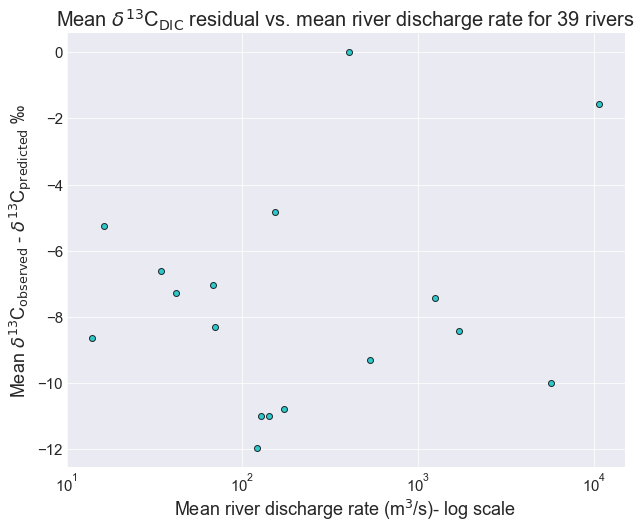

In [12]:
x=average_d13c['discharge']
print(len(x))
plt.figure(figsize=(10,8))
plt.scatter(x,r,c='c',alpha=0.8,edgecolor='k')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Mean $\delta^{13}$C$_{\mathrm{observed}}$ - $\delta^{13}$C$_{\mathrm{predicted}}$ ‰',fontsize=18)
plt.xlabel('Mean river discharge rate (m$^3$/s)- log scale',fontsize=18)
plt.title('Mean $\delta^{13}$C$_{\mathrm{DIC}}$ residual vs. mean river discharge rate for 39 rivers', fontsize=20)
plt.xscale('log')

In [13]:
#python lesson: take caution when copying lists! 
#if original data is maniuplated in later ines, it will still change the copied list
a=[1,2,3]
b=a
print(b)
a[0]=100 #mutation: applies to ALL copies of OG list- not if you do copy.deepcopy
b

[1, 2, 3]


[100, 2, 3]